# 练习

下面使用一个实际数据集进行时间序列数据处理的练习。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 导入数据

这里使用读取股票的交易数据，数据格式为csv文件，包括如下字段：
- `date`，交易
- `open`，当日开盘价
- `close`，当日收盘价
- `high`，当日最高价
- `low`，当日开盘价
- `volumn`，成交量
- `code`, 股票代码

下面随机选择一个股票文件并导入数据：

In [2]:
import os
import random

stockcodes = ['300137', '300059', '601288', '600019', '000651'] 
stockcode = random.choice(stockcodes)
csvfile = os.path.join('..', 'data', 'stocks', '{}_lday.csv'.format(stockcode))
# 导入数据，解析日期并设为索引
stockdata = pd.read_csv(csvfile, parse_dates=['date'], index_col=['date'])
stockdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 657 entries, 2016-01-04 to 2019-01-25
Data columns (total 6 columns):
open      657 non-null float64
close     657 non-null float64
high      657 non-null float64
low       657 non-null float64
volume    657 non-null float64
code      657 non-null int64
dtypes: float64(5), int64(1)
memory usage: 35.9 KB


In [3]:
stockdata.sample(10)

,open,close,high,low,volume,code
date,,,,,,
2017-03-16,6.353,6.362,6.417,6.316,557577.0,600019
2018-01-02,8.264,8.521,8.550,8.236,1091646.0,600019
2017-12-27,7.931,7.960,8.103,7.893,630842.0,600019
2017-04-28,5.662,5.745,5.763,5.653,543604.0,600019
2016-10-31,5.174,5.165,5.202,5.156,269504.0,600019
2016-11-21,5.506,5.478,5.561,5.441,388280.0,600019
2018-01-10,8.559,8.607,8.683,8.502,686459.0,600019
2017-12-13,7.903,8.055,8.131,7.865,522404.0,600019
2018-08-01,8.880,8.360,8.940,8.320,931313.0,600019


## 绘制K线图

下面绘制股票数据的K线图。首先定义两个函数
- `candlestick()`：绘制K线
- `set_xtick()`：设置日期

In [4]:
def candlestick(axes, xindex, data, colorup='red', colordown='green'):
    """绘制K线"""
    up = data['close']  >= data['open']
    down = data['close']  < data['open']

    if any(up):
        axes.vlines(xindex[up], data['open'][up], data['close'][up], color=colorup, linewidth=5.5)
        axes.vlines(xindex[up], data['low'][up], data['high'][up], color=colorup, linewidth=1)

    if any(down):
        axes.vlines(xindex[down], data['open'][down], data['close'][down], color=colordown, linewidth=5.5)
        axes.vlines(xindex[down], data['high'][down], data['low'][down], color=colordown, linewidth=1)

In [5]:
def set_xtick(axes, xindex, data, datefmt='%y-%m-%d', nticks=8):
    dates = np.array(df.index.to_pydatetime())
    sdates = [date.strftime(datefmt) for date in dates]
    step = len(xindex) // nticks
    axes.set_xticks(xindex[::step])
    axes.set_xticklabels(sdates[::step], rotation=30)

下面来绘制K线图：

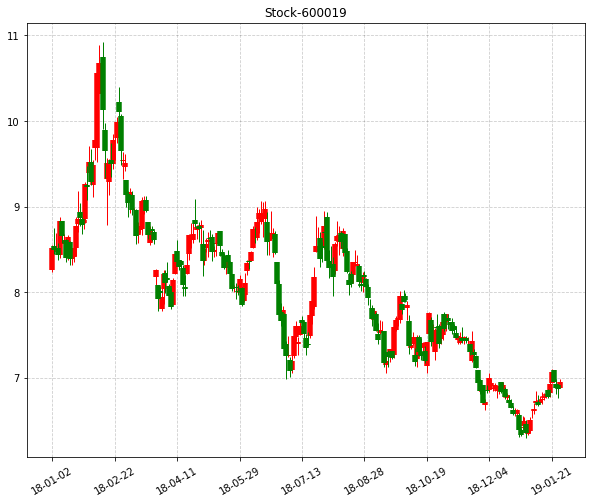

In [6]:
# 选择数据
obsdate = '2018-01-01'
df = stockdata[obsdate:]
# 绘图
plt.figure(figsize=(10, 8))
axes = plt.gca()
xindex = np.arange(len(df))
candlestick(axes, xindex, df)
set_xtick(axes, xindex, df)
axes.grid(True, color='k', ls='--', alpha=0.2)
plt.title('Stock-{}'.format(stockcode))
plt.show()

## 使用移位操作计算收益

一次交易就是买入并卖出的过程。假定当日收盘价买入，指定几日后以收盘价卖出，其差价就是一次交易的收益。使用`shift()`移位操作计算指定日期的收益率：

In [7]:
ndays = 5
stockdata['rate_of_return'] = (stockdata['close'].shift(-ndays) / stockdata['close'] - 1) * 100
# 填充NAN值
stockdata['rate_of_return'] = stockdata['rate_of_return'].fillna(0)
# 收益率大于 0.5% 的交易称为成功交易
stockdata['success'] = np.where(stockdata['rate_of_return'] > 0.005, 1, -1)

可以得出交易中成功与失败的次数：

In [8]:
stockdata['success'].value_counts()

 1    342
-1    315
Name: success, dtype: int64

下面绘制出交易收益率的分布：

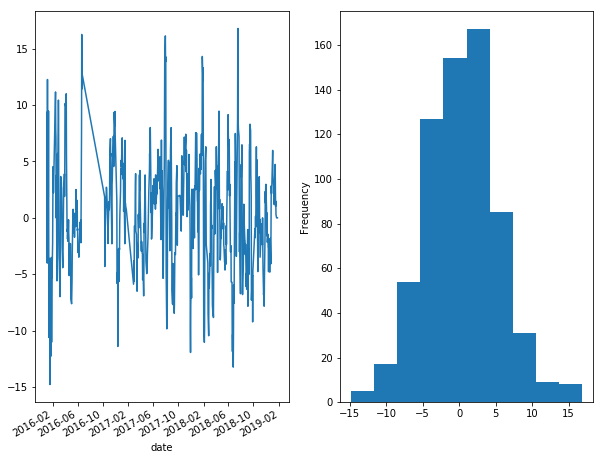

In [9]:
plt.figure(figsize=(10,8))
plt.subplot(1, 2, 1)
stockdata['rate_of_return'].plot()
plt.subplot(1, 2, 2)
stockdata['rate_of_return'].plot('hist')

从中可见，大部分交易收益率在零附近，而且输多胜少。

## 计算移动均线

使用`rolling()`来计算移动均线，例如下面计算5日、10日与20日移动均线：

In [10]:
stockdata['mhlc'] = (stockdata['high'] + stockdata['low'] + stockdata['close'] * 2) / 4
stockdata['ma5'] = stockdata['mhlc'].rolling(5).mean()
stockdata['ma10'] = stockdata['mhlc'].rolling(10).mean()
stockdata['ma20'] = stockdata['mhlc'].rolling(20).mean()

下面绘制K线，同时加上5日与20日均线：

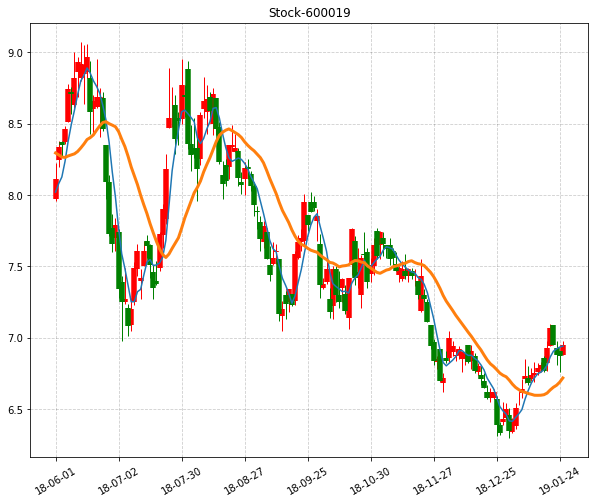

In [11]:
obsdate = '2018-06-01'
df = stockdata[obsdate:]

plt.figure(figsize=(10,8))
axes = plt.gca()
xindex = np.arange(len(df))
candlestick(axes, xindex, df)
set_xtick(axes, xindex, df)
plt.plot(xindex, df['ma5'])
plt.plot(xindex, df['ma20'], linewidth=3)
axes.grid(True, color='k', ls='--', alpha=0.2)
plt.title('Stock-{}'.format(stockcode))
plt.show()

## 使用重采样计算周线数据

下面使用重采样`resample()`把日线数据转换为周线数据：

In [12]:
weekdata = pd.DataFrame()
weekdata['open'] = stockdata['open'].resample('W-FRI').first()
weekdata['high'] = stockdata['high'].resample('W-FRI').max()
weekdata['low'] = stockdata['low'].resample('W-FRI').min()
weekdata['close'] = stockdata['close'].resample('W-FRI').last()
weekdata.dropna(inplace=True)

同样计算移动均线：

In [13]:
weekdata['wma5'] = weekdata['close'].rolling(5).mean()
weekdata['wma10'] = weekdata['close'].rolling(10).mean()
weekdata['wma20'] = weekdata['close'].rolling(20).mean()
weekdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 2016-01-08 to 2019-01-25
Data columns (total 7 columns):
open     138 non-null float64
high     138 non-null float64
low      138 non-null float64
close    138 non-null float64
wma5     134 non-null float64
wma10    129 non-null float64
wma20    119 non-null float64
dtypes: float64(7)
memory usage: 8.6 KB


下面把日线与周线数据合在一起，需要注意的是为了防止使用未来数据，当日对应的周线应该是上周的数据：

In [14]:
# 使用上周数据
weekdata = weekdata.shift(1)
# 向下采样
weekdata = weekdata.resample('B').bfill()
weekdata.tail()

,open,high,low,close,wma5,wma10,wma20
date,,,,,,,
2019-01-21,6.74,6.98,6.69,6.93,6.66,6.825,7.226
2019-01-22,6.74,6.98,6.69,6.93,6.66,6.825,7.226
2019-01-23,6.74,6.98,6.69,6.93,6.66,6.825,7.226
2019-01-24,6.74,6.98,6.69,6.93,6.66,6.825,7.226
2019-01-25,6.74,6.98,6.69,6.93,6.66,6.825,7.226


下面使用日线索引重建周线索引：

In [15]:
weekdata = weekdata.reindex(stockdata.index)
weekdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 657 entries, 2016-01-04 to 2019-01-25
Data columns (total 7 columns):
open     652 non-null float64
high     652 non-null float64
low      652 non-null float64
close    652 non-null float64
wma5     632 non-null float64
wma10    607 non-null float64
wma20    559 non-null float64
dtypes: float64(7)
memory usage: 61.1 KB


把周线数据合并到日线中，这里仅使用周线的移动均线数据：

In [17]:
stockdata['wma5'] = weekdata['wma5']
stockdata['wma10'] = weekdata['wma10']
stockdata['wma20'] = weekdata['wma20']
stockdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 657 entries, 2016-01-04 to 2019-01-25
Data columns (total 15 columns):
open              657 non-null float64
close             657 non-null float64
high              657 non-null float64
low               657 non-null float64
volume            657 non-null float64
code              657 non-null int64
rate_of_return    657 non-null float64
success           657 non-null int32
mhlc              657 non-null float64
ma5               653 non-null float64
ma10              648 non-null float64
ma20              638 non-null float64
wma5              632 non-null float64
wma10             607 non-null float64
wma20             559 non-null float64
dtypes: float64(13), int32(1), int64(1)
memory usage: 99.6 KB


下面绘制 K 线，并添加日线移动均线以及周的移动均线：

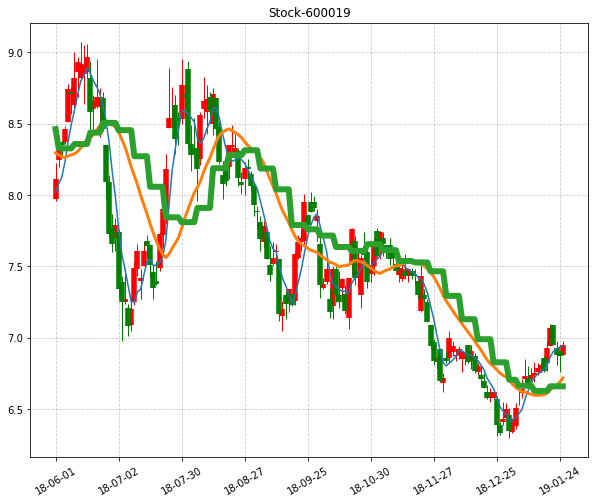

In [18]:
obsdate = '2018-06-01'
df = stockdata[obsdate:]

plt.figure(figsize=(10,8))
axes = plt.gca()
xindex = np.arange(len(df))
candlestick(axes, xindex, df)
set_xtick(axes, xindex, df)
plt.plot(xindex, df['ma5'])
plt.plot(xindex, df['ma20'], linewidth=3)
plt.plot(xindex, df['wma5'], linewidth=6)
axes.grid(True, color='k', ls='--', alpha=0.2)
plt.title('Stock-{}'.format(stockcode))
plt.show()

## 策略练习

策略就是基于某个条件来选择买入时机，使得成功交易占比更多，收益更大。例如，选择开盘价大于5日均线，20日均线向上：

In [19]:
conds1 = stockdata['open'] > stockdata['ma5']
conds2 = stockdata['ma20'].diff() < 0
conds = np.logical_and(conds1, conds2)
# 买入
buytrades = stockdata[conds]
# 交易成功与失败计数
buytrades['success'].value_counts()

 1    81
-1    47
Name: success, dtype: int64

打印出最终收益率：

In [20]:
print(len(buytrades)*0.005, (buytrades['rate_of_return']*0.01 + 1).cumprod()[-1])

0.64 5.972006396366103


绘制收益率分布：

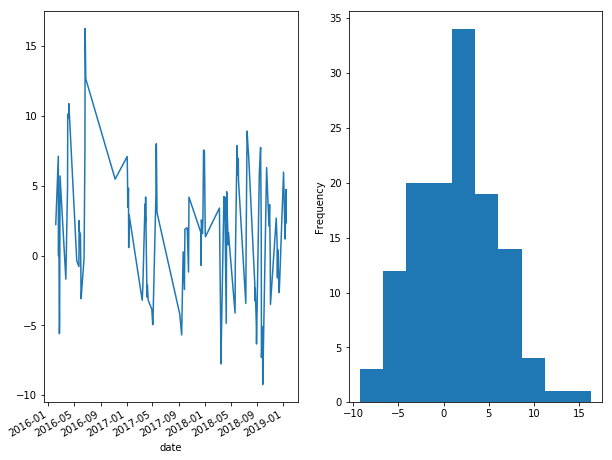

In [21]:
plt.figure(figsize=(10,8))
plt.subplot(1, 2, 1)
buytrades['rate_of_return'].plot()
plt.subplot(1, 2, 2)
buytrades['rate_of_return'].plot('hist')

这里纯粹是为了练习时间序列数据而给出的策略，大家千万不要据此而进行操作。